# Implémentez un modèle de scoring

## Import

In [1]:
# Classique
import pandas as pd
import numpy as np
import re
import joblib
import time
import collections

# Visu
import missingno as msno
import seaborn as sns
import matplotlib. pyplot as plt

# utils
import utils

# MLFlow
from mlflow.models.signature import infer_signature
import mlflow.sklearn

# Sklearn
from sklearn.feature_selection import SelectKBest, mutual_info_classif, VarianceThreshold
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## Data

In [2]:
df_app = pd.read_csv('Data/application_train.csv')

### Aperçu des données

Check des valeurs manquantes, duplicata, type et dimension de nos données

In [3]:
df_app.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

<AxesSubplot: >

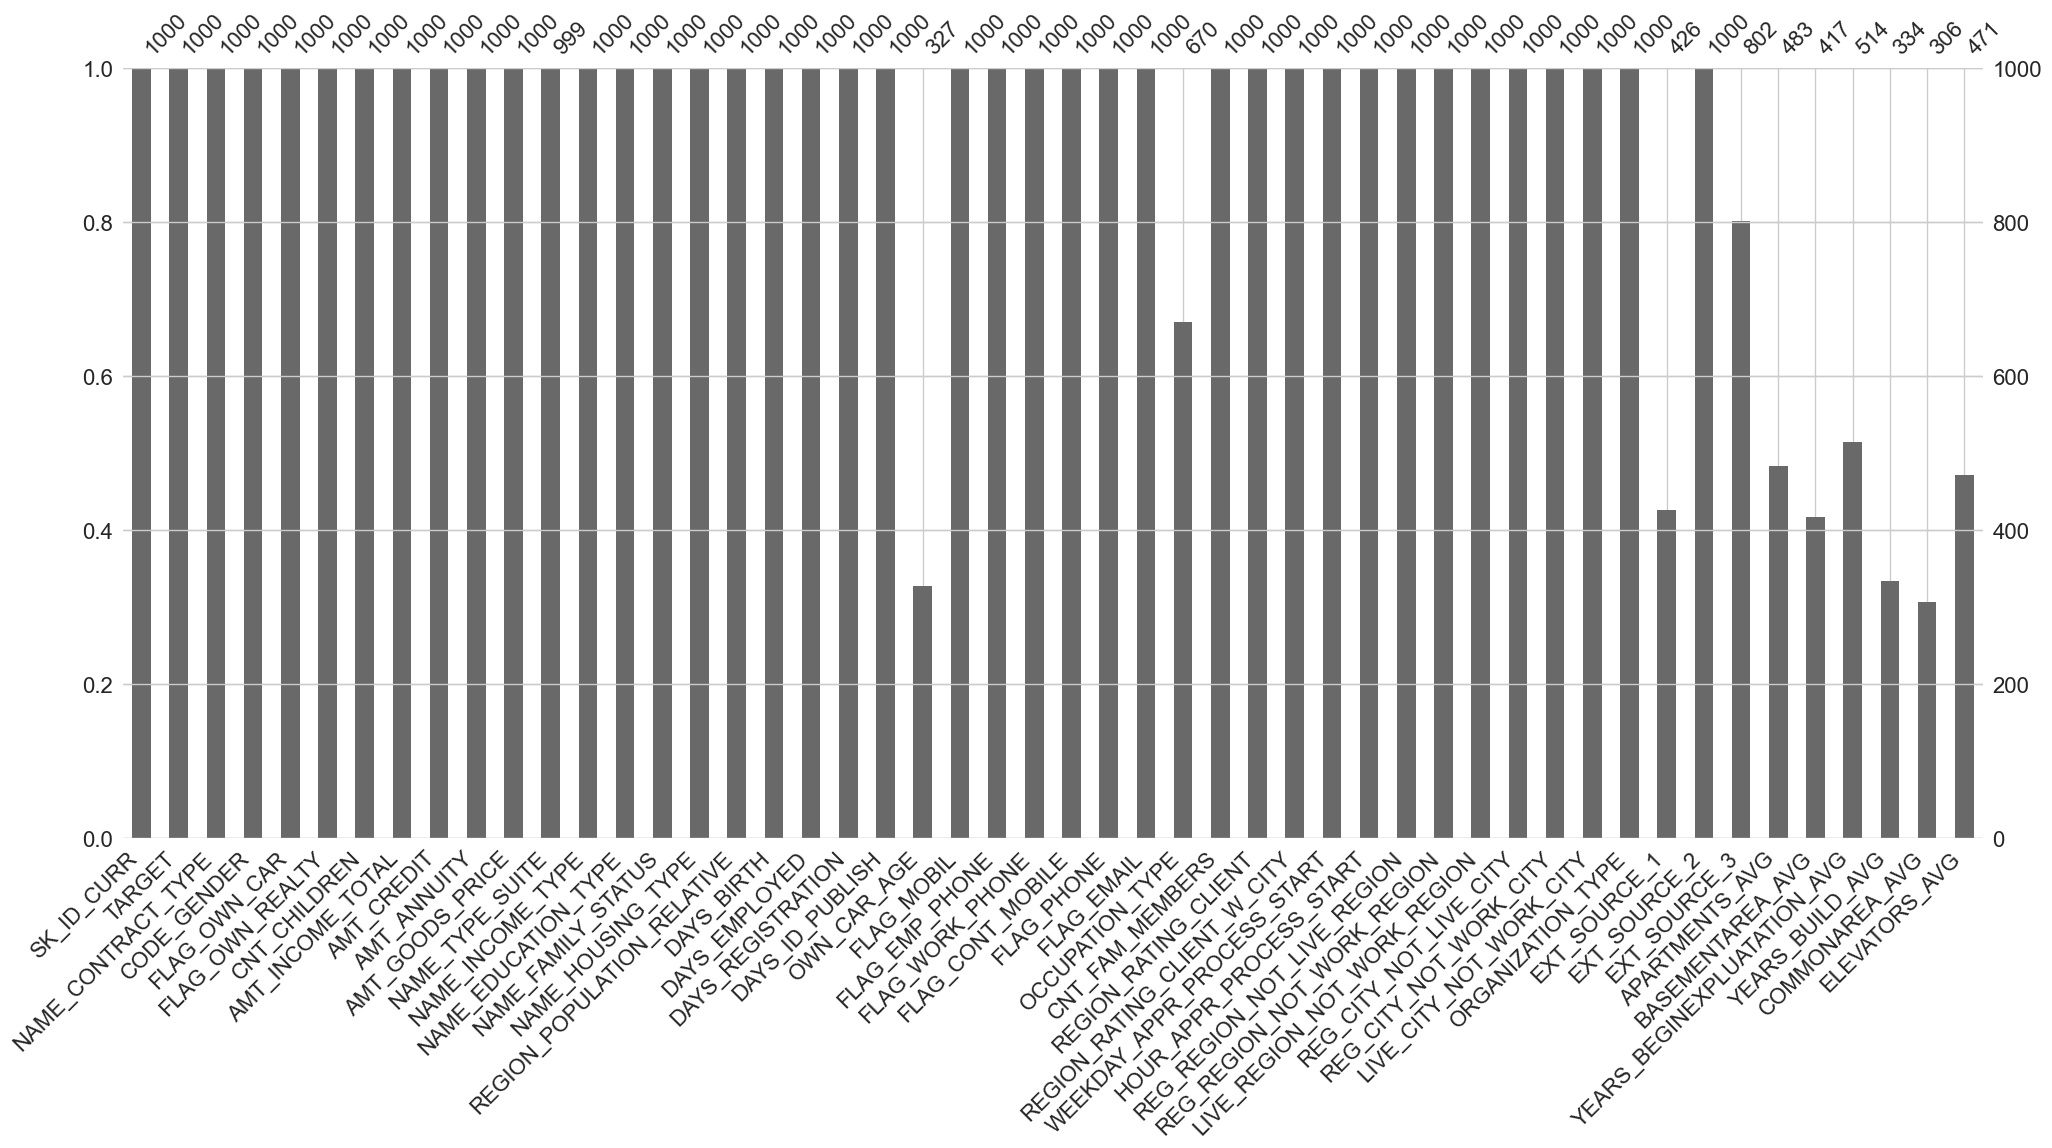

In [4]:
msno.bar(df_app.iloc[:, 0:50].sample(1000))

<AxesSubplot: >

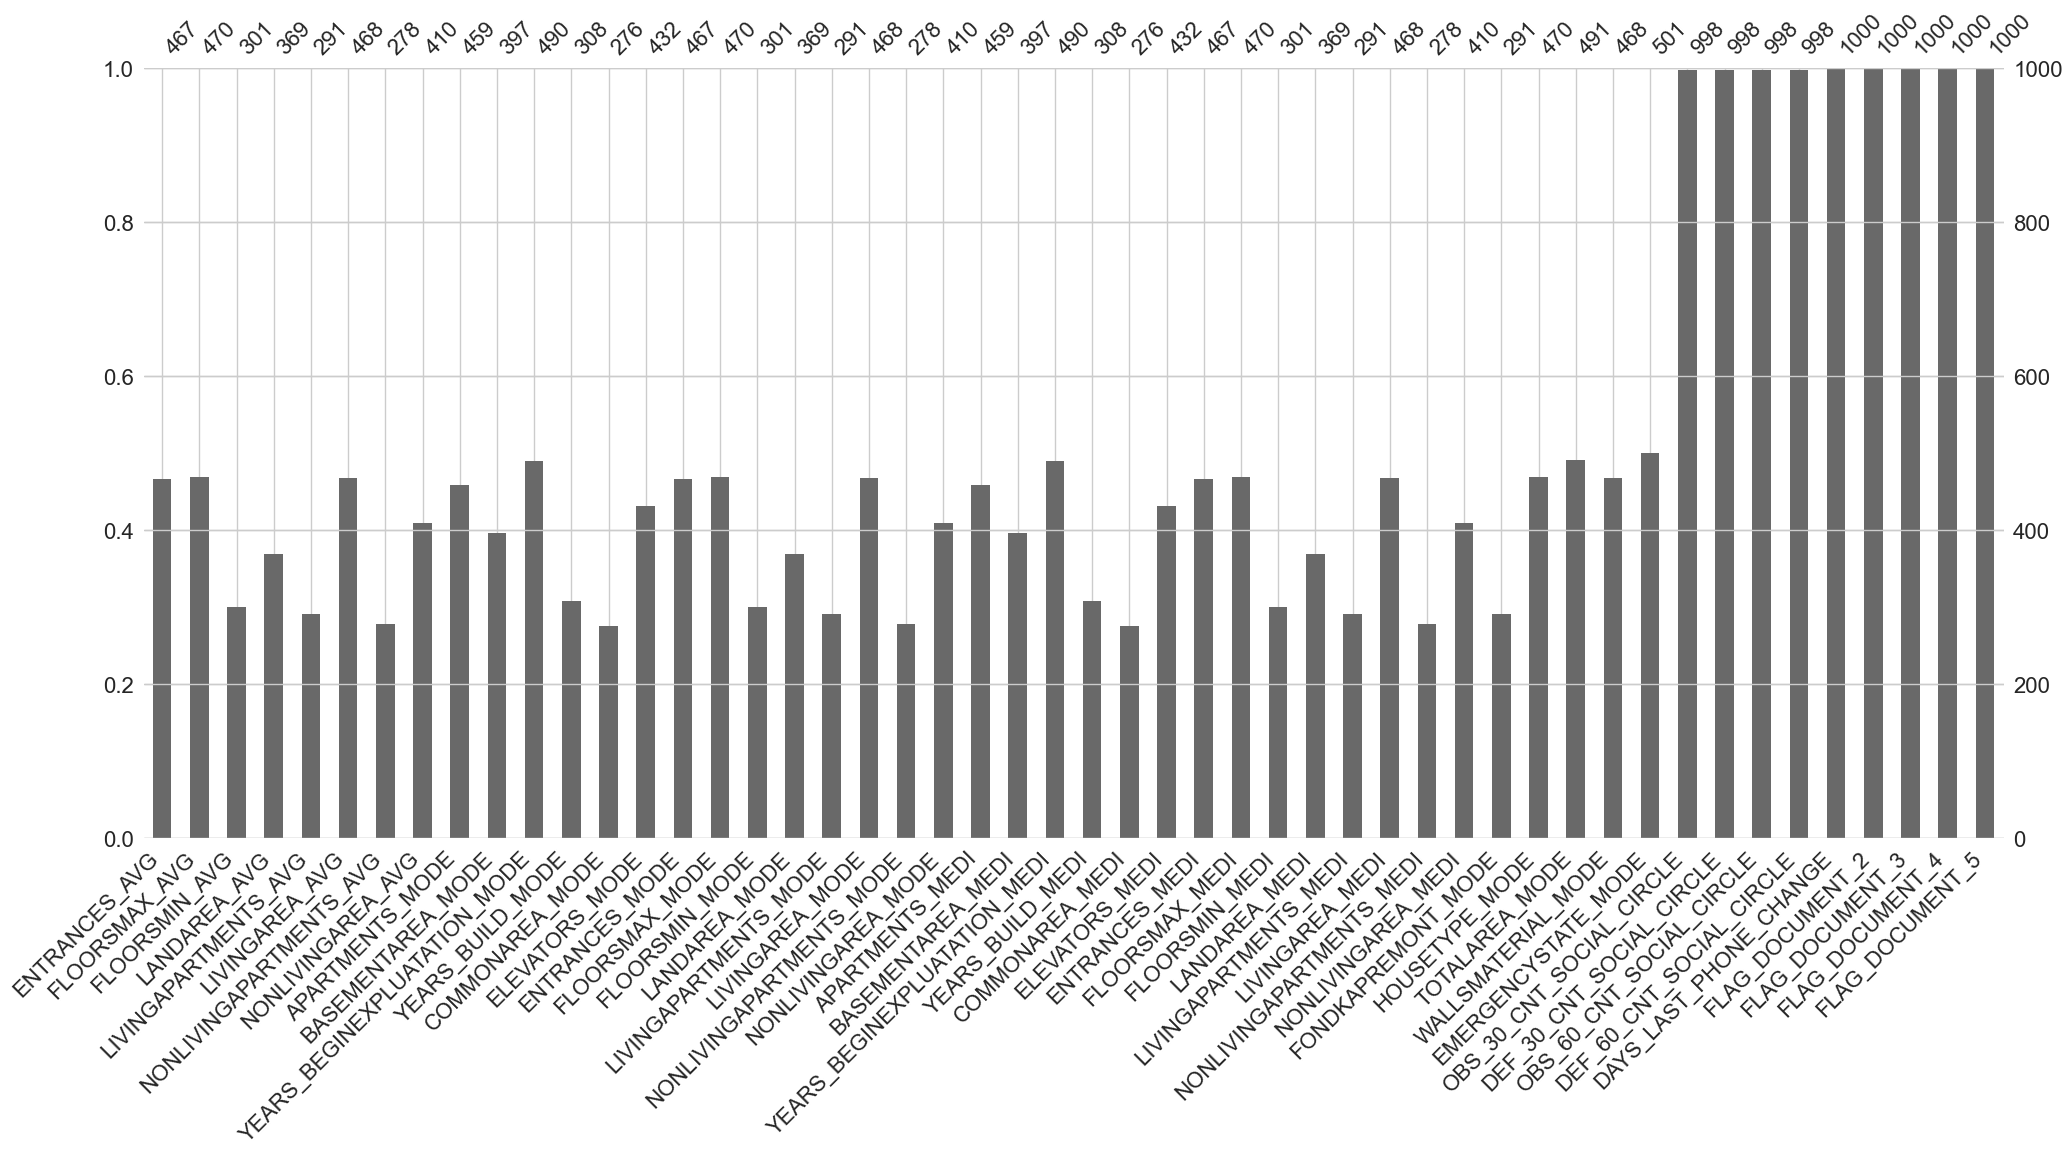

In [5]:
msno.bar(df_app.iloc[:, 50:100].sample(1000))

<AxesSubplot: >

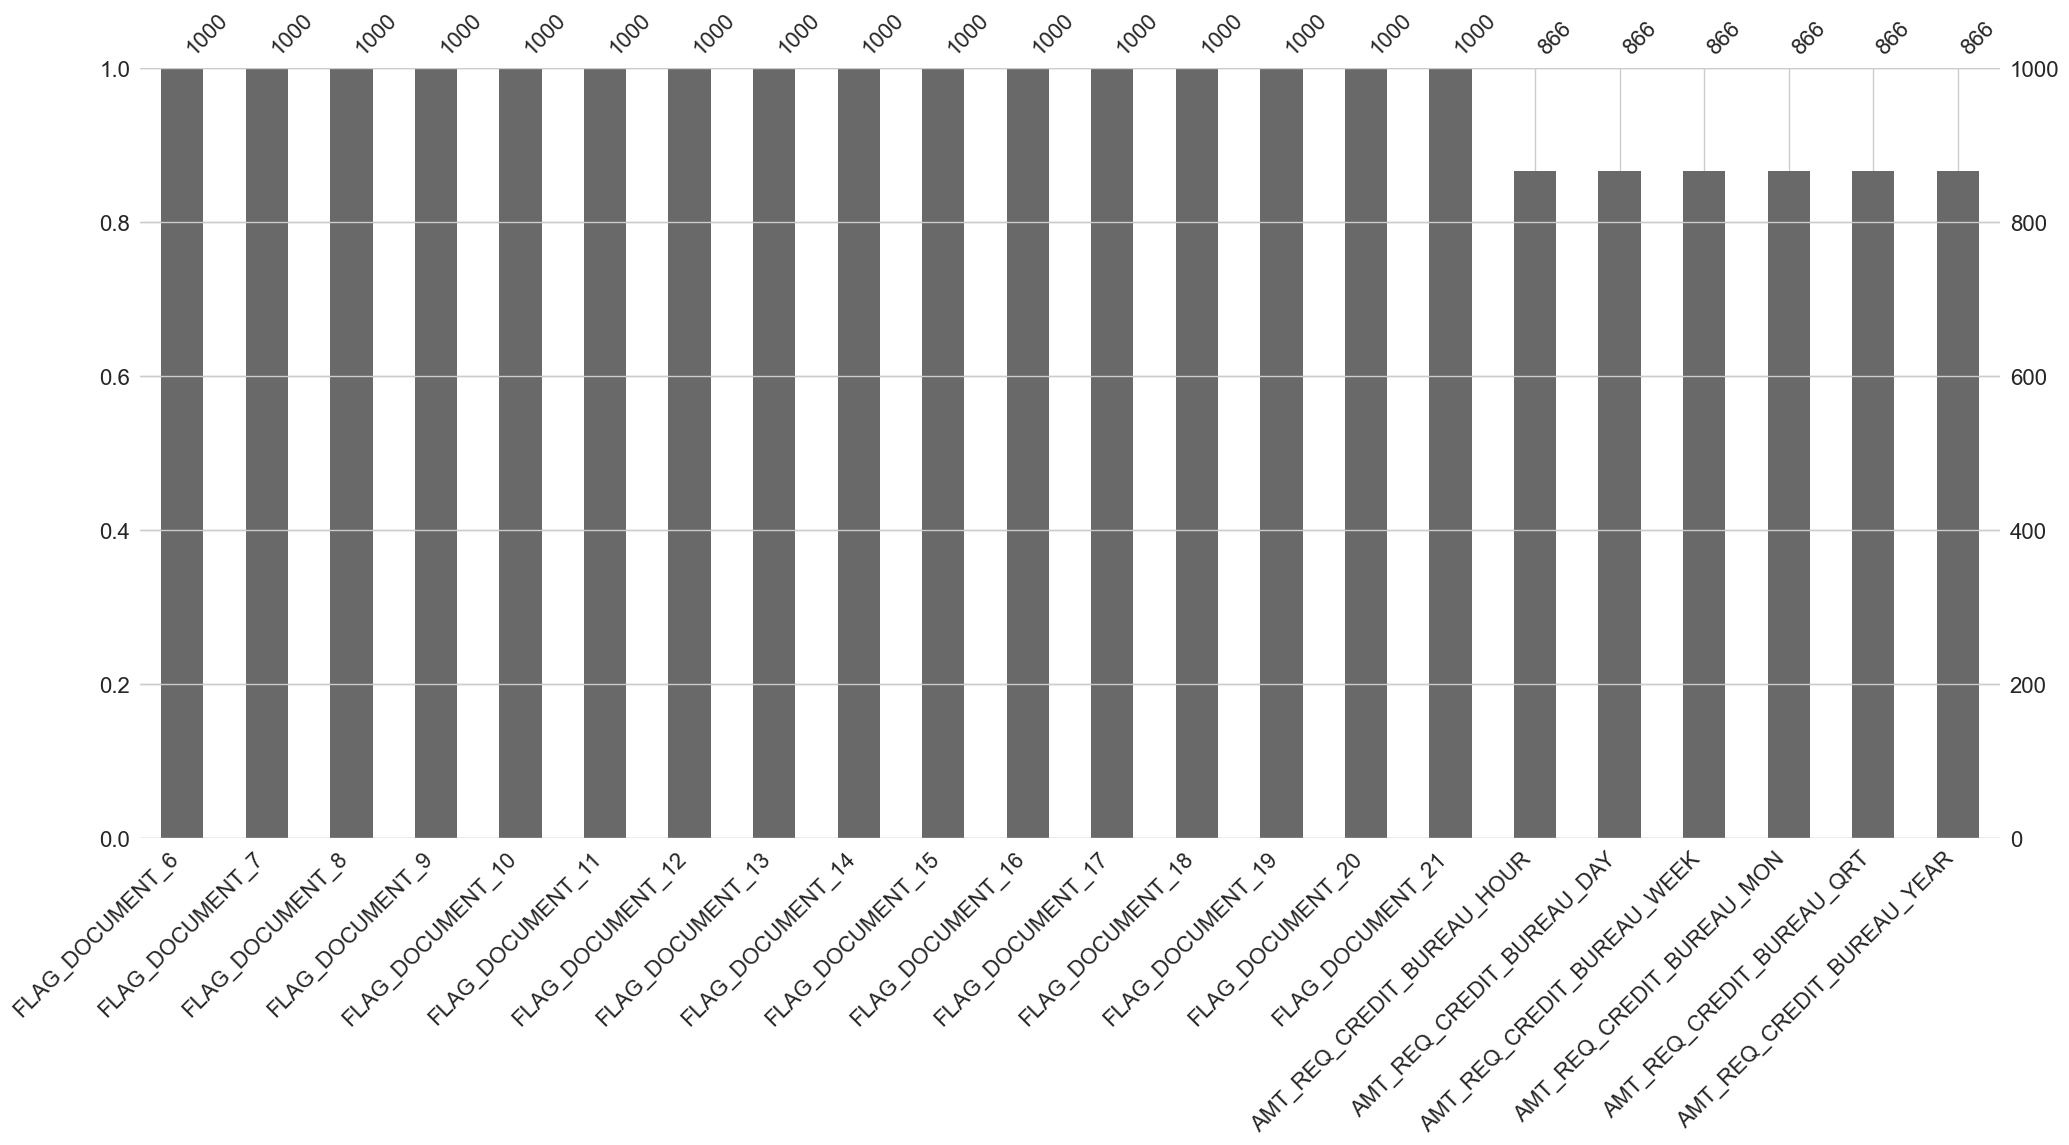

In [6]:
msno.bar(df_app.iloc[:, 100:].sample(1000))

In [7]:
df_app['SK_ID_CURR'].duplicated().sum()

0

## EDA

### Analyse de Target

[Text(0, 0, '91.93 %'), Text(0, 0, '8.07 %')]

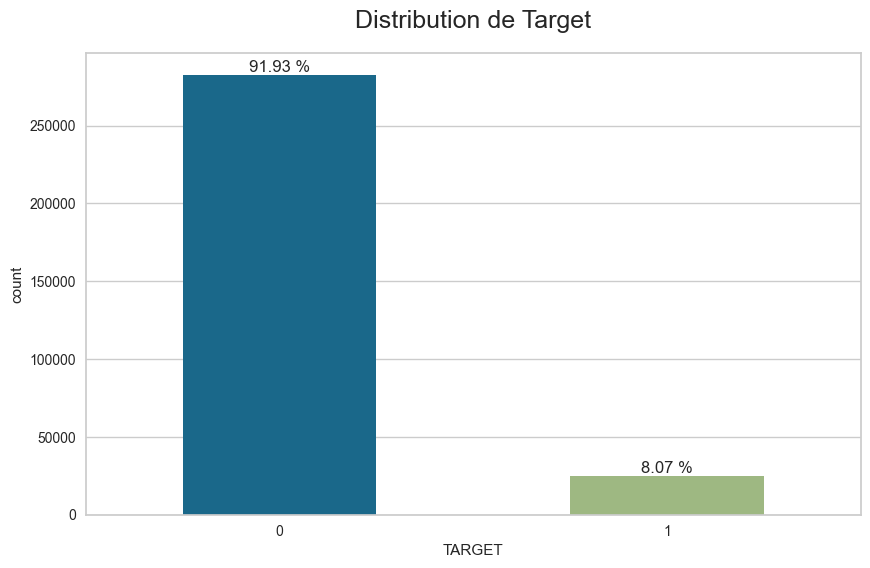

In [8]:
# Affichage de la distribution de notre cible
# 0 : pas de problème de remboursement du crédit
# 1 : difficulté a rembourser

fig, ax = plt.subplots(figsize = (10,6))

data = df_app.copy()

sns.countplot(ax = ax, data = data, x='TARGET', width = 0.5, saturation = 0.7)

ax.set_title('Distribution de Target', fontsize = 18, pad = 18)

bar_lbl = ax.containers[0].datavalues*100 / df_app.shape[0]
bar_lbl = [str(round(x, 2)) + ' %' for x in bar_lbl]
ax.bar_label(ax.containers[0], labels = bar_lbl)

Distribution des classes déséquilibrées

[Text(0, 0, '61.23 %'), Text(0, 0, '4.61 %')]

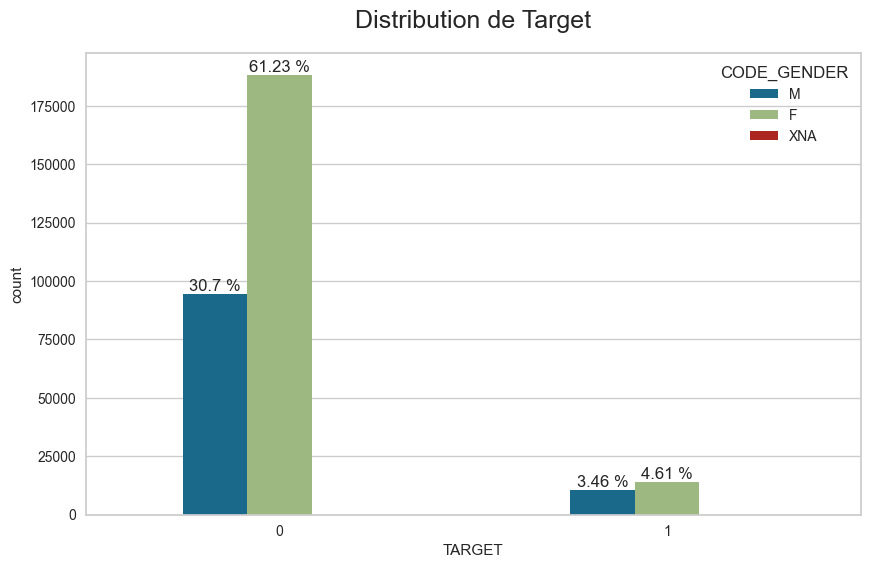

In [9]:
fig, ax = plt.subplots(figsize = (10,6))

data = df_app.copy()

sns.countplot(ax = ax, data = data, x='TARGET', hue='CODE_GENDER', width = 0.5, saturation = 0.7)

ax.set_title('Distribution de Target', fontsize = 18, pad = 18)

bar_lbl = ax.containers[0].datavalues*100 / df_app.shape[0]
bar_lbl = [str(round(x, 2)) + ' %' for x in bar_lbl]
ax.bar_label(ax.containers[0], labels = bar_lbl)

bar_lbl = ax.containers[1].datavalues*100 / df_app.shape[0]
bar_lbl = [str(round(x, 2)) + ' %' for x in bar_lbl]
ax.bar_label(ax.containers[1], labels = bar_lbl)

In [10]:
df_app.CODE_GENDER.value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

## Feature Engineering

In [11]:
# Utilisation d'un kernel kaggle pour le feature engineering
# https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

num_rows = None
nan_as_category = False

start = time.time()
df_to_export = utils.application_train_test(num_rows)
print("Application df shape:", df_to_export.shape)

bureau = utils.bureau_and_balance(num_rows, nan_as_category)
print("Bureau df shape:", bureau.shape)
df_to_export = df_to_export.join(bureau, how='left', on='SK_ID_CURR')


prev = utils.previous_applications(num_rows, nan_as_category)
print("Previous applications df shape:", prev.shape)
df_to_export = df_to_export.join(prev, how='left', on='SK_ID_CURR')
del prev


pos = utils.pos_cash(num_rows, nan_as_category)
print("Pos-cash balance df shape:", pos.shape)
df_to_export = df_to_export.join(pos, how='left', on='SK_ID_CURR')
del pos

ins = utils.installments_payments(num_rows, nan_as_category)
print("Installments payments df shape:", ins.shape)
df_to_export = df_to_export.join(ins, how='left', on='SK_ID_CURR')
del ins

cc = utils.credit_card_balance(num_rows, nan_as_category)
print("Credit card balance df shape:", cc.shape)
df_to_export = df_to_export.join(cc, how='left', on='SK_ID_CURR')
del cc

# drop de qqs rows avec des valeurs np.inf
avt = df_to_export.shape[0]
df_to_export.drop(df_to_export.iloc[df_to_export.values==np.inf].index, 
                  inplace=True)
aprs = df_to_export.shape[0]
print("Drop de {} rows ayant des valeurs anormales.".format(avt - aprs))



# Séparation des deux datasets
train_df = df_to_export[df_to_export['TARGET'].notnull()]
test_df = df_to_export[df_to_export['TARGET'].isnull()]

# On remet TARGET en integer (changement du à la concaténation
# avec le dataset test qui n'a pas de colonne TARGET)
# et qq cols mal typées
train_df = train_df.astype({'TARGET': 'int64', 
                            'DAYS_BIRTH': 'float64',
                            'DAYS_ID_PUBLISH': 'float64'})
test_df = test_df.astype({'DAYS_BIRTH': 'float64',
                          'DAYS_ID_PUBLISH': 'float64'})

# drop des colonnes avec plus de 70% de valeurs manquantes
# (threshold à ajuster plus tard)
th_nan = 0.3
avt = train_df.shape[1]
train_df.dropna(thresh=int(train_df.shape[0]*th_nan), axis=1, inplace=True)
aprs = train_df.shape[1]
print("Drop de {} colonnes possedant plus de {}% de valeurs manquantes.".format(avt - aprs, (1 - th_nan)*100))

tps_traitement = np.round(time.time() - start, 2)

print('--------------------------')
print('Temps total du feature engineering: {}s'.format(tps_traitement))
print('Dataframe finale shape')
print('Train dataset :{}'.format(train_df.shape))
      
print(train_df['TARGET'].value_counts(normalize=True))

Train size: 307511
Test size: 48744


C:\Users\julie\OpenClassrooms\Projet_7\utils.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_test).reset_index()


Application df shape: (356251, 248)
Bureau df shape: (305811, 112)
Previous applications df shape: (338857, 249)
Pos-cash balance df shape: (337252, 18)
Installments payments df shape: (339587, 26)
Credit card balance df shape: (103558, 141)
Drop de 20 rows ayant des valeurs anormales.
Drop de 175 colonnes possedant plus de 70.0% de valeurs manquantes.
--------------------------
Temps total du feature engineering: 118.76s
Dataframe finale shape
Train dataset :(307488, 619)
0    0.919272
1    0.080728
Name: TARGET, dtype: float64


## Feature Selection

Réduction du nombre de variables en supprimant celles qui ont une variance très faible.

In [12]:
X = train_df.drop(['TARGET', 'index', 'SK_ID_CURR'], axis=1)

th = 0.001
var_selector = VarianceThreshold(th)
var_selector.set_output(transform='pandas')
var_selector.fit(X)

mask_low_var = var_selector.get_support()
diff = X.shape[1] - mask_low_var.sum()
print("Drop de {} colonnes ayant une variance faible (<{})".format(diff, th))

Drop de 109 colonnes ayant une variance faible (<0.001)


In [13]:
X_reduced =  X.loc[:, mask_low_var]
X_test = X_reduced.select_dtypes(include='float64')
corr_matrix = X_test.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print('There are %d columns to remove.' % (len(to_drop)))
print(to_drop)

temp_feats = [col for col in X_reduced.columns if col not in to_drop]
print("Nombre de features retenues actuellement : {}".format(len(temp_feats)))

There are 102 columns to remove.
['AMT_GOODS_PRICE', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_EMPLOYED_PERC', 'BURO_AMT_CREDIT_SUM_DEBT_SUM', 'BURO_CREDIT_ACTIVE_Closed_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX', 'ACTIVE_CREDIT_DAY_OVERDUE_MAX', 'ACTIVE_AMT_CREDIT_SUM_SUM', 'ACTIVE_AMT_CREDIT_SUM_DEBT_MAX', 'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM', 'ACTIVE_AMT_CREDIT_

Analyse importance des features basés sur test statistique

In [14]:
# Imputation simple pour réaliser test stat
num_features = make_column_selector(dtype_include = ['float64'])

pipe_num = Pipeline([
    ("impnum", SimpleImputer(strategy = 'median'))
])

cat_features = make_column_selector(dtype_exclude = ['float64'])
pipe_cat = Pipeline([
    ("impcat", SimpleImputer(strategy = 'most_frequent'))
])

preprocessor = make_column_transformer((pipe_num, num_features),
                                       (pipe_cat, cat_features))


In [15]:
X_reduced2 = X[temp_feats].copy()
print('Imputation missing values...')
X_red_imp = preprocessor.fit_transform(X_reduced2)
names = preprocessor.get_feature_names_out()
feature_names = []
for name in names:
    name1 = name.replace('pipeline-1__', '')
    name2 = name1.replace('pipeline-2__', '')
    feature_names.append(name2)

X_red_imp_df = pd.DataFrame(X_red_imp, columns=feature_names)
y = train_df['TARGET']

nb_fl = preprocessor.named_transformers_['pipeline-1'].n_features_in_
nb_int = preprocessor.named_transformers_['pipeline-2'].n_features_in_
print('Variables continues : ', nb_fl)
print('Variables discrètes : ', nb_int)
int_columns_indices = list(range(nb_fl , nb_fl + nb_int))

for i, col in enumerate(X_red_imp_df.columns):
    if i in int_columns_indices:
        X_red_imp_df[col] = X_red_imp_df[col].astype('int')

print('Calcul score mutual info classif...')
mic_scores = mutual_info_classif(X_red_imp_df, y)
print('Done !')

Imputation missing values...
Variables continues :  260
Variables discrètes :  145
Calcul score mutual info classif...
Done !


Text(0.5, 1.0, 'Feature importance basé sur mutual_info_classif')

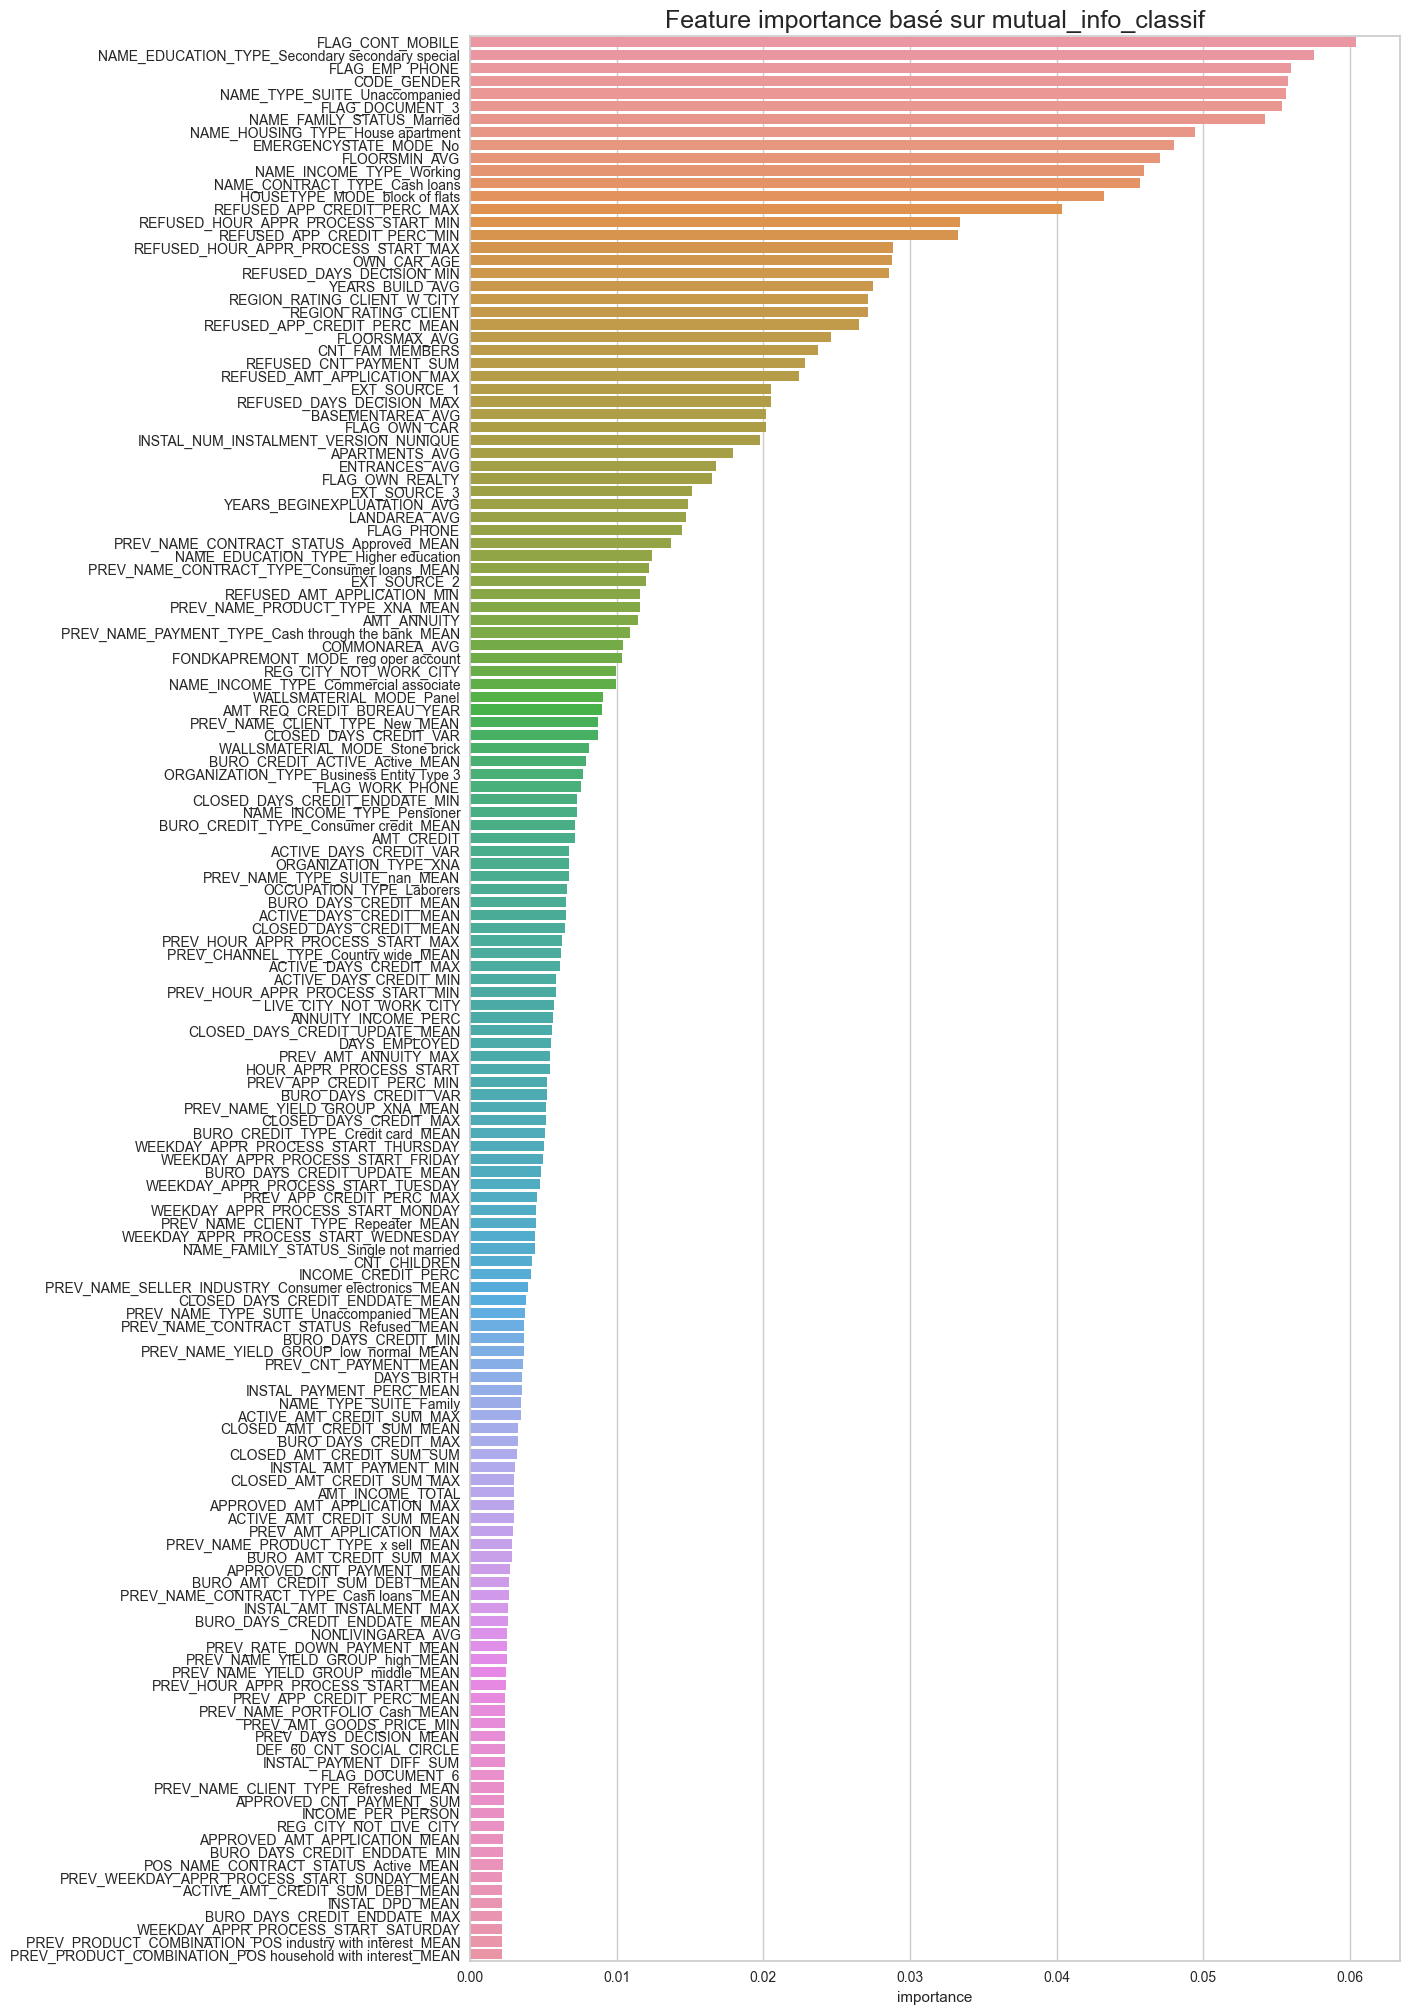

In [16]:
idx = np.argsort(-1*mic_scores)
d = {'feature' : np.array(feature_names)[idx],
     'importance' : mic_scores[idx]
    }
best_features = pd.DataFrame(data=d)

fig, ax = plt.subplots(figsize=(12,25))
sns.barplot(x="importance", y="feature", data=best_features.iloc[:150,:])
ax.set_ylabel(None)
ax.set_title('Feature importance basé sur mutual_info_classif',  fontsize = 18)

Analyse corrélation entre nos variables.
On cherche à supprimer les variables trop corrélées entre elles,
en conservant celle qui a eu le meilleur score (mutual_info_classif).

In [17]:
final_feats = np.array(feature_names)[idx][:200]
print("Nombre de features retenues au final : {}".format(len(final_feats)))

X_reduced2 = X_reduced2.loc[:, final_feats]
print(X_reduced2.dtypes.value_counts())
X_reduced2.head()

Nombre de features retenues au final : 200
float64    154
uint8       30
int64       16
dtype: int64


,FLAG_CONT_MOBILE,NAME_EDUCATION_TYPE_Secondary secondary special,FLAG_EMP_PHONE,CODE_GENDER,NAME_TYPE_SUITE_Unaccompanied,FLAG_DOCUMENT_3,NAME_FAMILY_STATUS_Married,NAME_HOUSING_TYPE_House apartment,EMERGENCYSTATE_MODE_No,FLOORSMIN_AVG,...,NAME_FAMILY_STATUS_Civil marriage,PREV_NAME_GOODS_CATEGORY_Mobile_MEAN,INSTAL_PAYMENT_DIFF_VAR,PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN,NONLIVINGAPARTMENTS_AVG,AMT_REQ_CREDIT_BUREAU_QRT,INSTAL_DBD_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN,PREV_APP_CREDIT_PERC_VAR,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN
0,1,1,1,0,1,1,0,1,1,0.1250,...,0,0.0,0.000000e+00,0.000000,0.0000,0.0,20.421053,0.000000,NaN,15994.2825
1,1,0,1,1,0,1,1,1,1,0.3333,...,0,0.0,0.000000e+00,0.000000,0.0039,0.0,7.160000,0.000000,0.005324,810000.0000
2,1,1,1,0,1,0,0,1,0,NaN,...,0,1.0,0.000000e+00,1.000000,NaN,0.0,7.666667,0.000000,NaN,NaN
3,1,1,1,1,1,1,0,1,0,NaN,...,1,0.0,0.000000e+00,0.000000,NaN,NaN,19.375000,0.666667,0.027041,NaN
4,1,1,1,0,1,0,0,1,0,NaN,...,0,0.0,8.084830e+06,0.166667,NaN,0.0,4.590909,0.166667,0.016456,NaN


## Sauvegarde des datasets

In [18]:
train_df = train_df[['SK_ID_CURR', 'TARGET'] + final_feats.tolist()]
test_df = test_df[['SK_ID_CURR'] + final_feats.tolist()]

train_df.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307488 entries, 0 to 307510
Data columns (total 202 columns):
 #    Column                                                     Non-Null Count   Dtype  
---   ------                                                     --------------   -----  
 0    SK_ID_CURR                                                 307488 non-null  int64  
 1    TARGET                                                     307488 non-null  int64  
 2    FLAG_CONT_MOBILE                                           307488 non-null  int64  
 3    NAME_EDUCATION_TYPE_Secondary secondary special            307488 non-null  uint8  
 4    FLAG_EMP_PHONE                                             307488 non-null  int64  
 5    CODE_GENDER                                                307488 non-null  int64  
 6    NAME_TYPE_SUITE_Unaccompanied                              307488 non-null  uint8  
 7    FLAG_DOCUMENT_3                                            307488 non-nu

In [19]:
train_df.to_csv('Data/train.csv', index=False)
test_df.to_csv('Data/test.csv', index=False)

---

## Clustering des clients

In [102]:
num_features = make_column_selector(dtype_include = ['float64'])

pipe_num = Pipeline([
    ("impnum", SimpleImputer(strategy = 'median')),
    ("sc", StandardScaler()),
])

cat_features = make_column_selector(dtype_exclude = ['float64'])
pipe_cat = Pipeline([
    ("impcat", SimpleImputer(strategy = 'most_frequent')),
    ("minmax", MinMaxScaler(feature_range=(-1, 1))),
])

preprocessor = make_column_transformer((pipe_num, num_features),
                                       (pipe_cat, cat_features))

C:\Users\julie\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\julie\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\julie\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\julie\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\julie\anaconda3\lib\site-packages\sklearn\clust

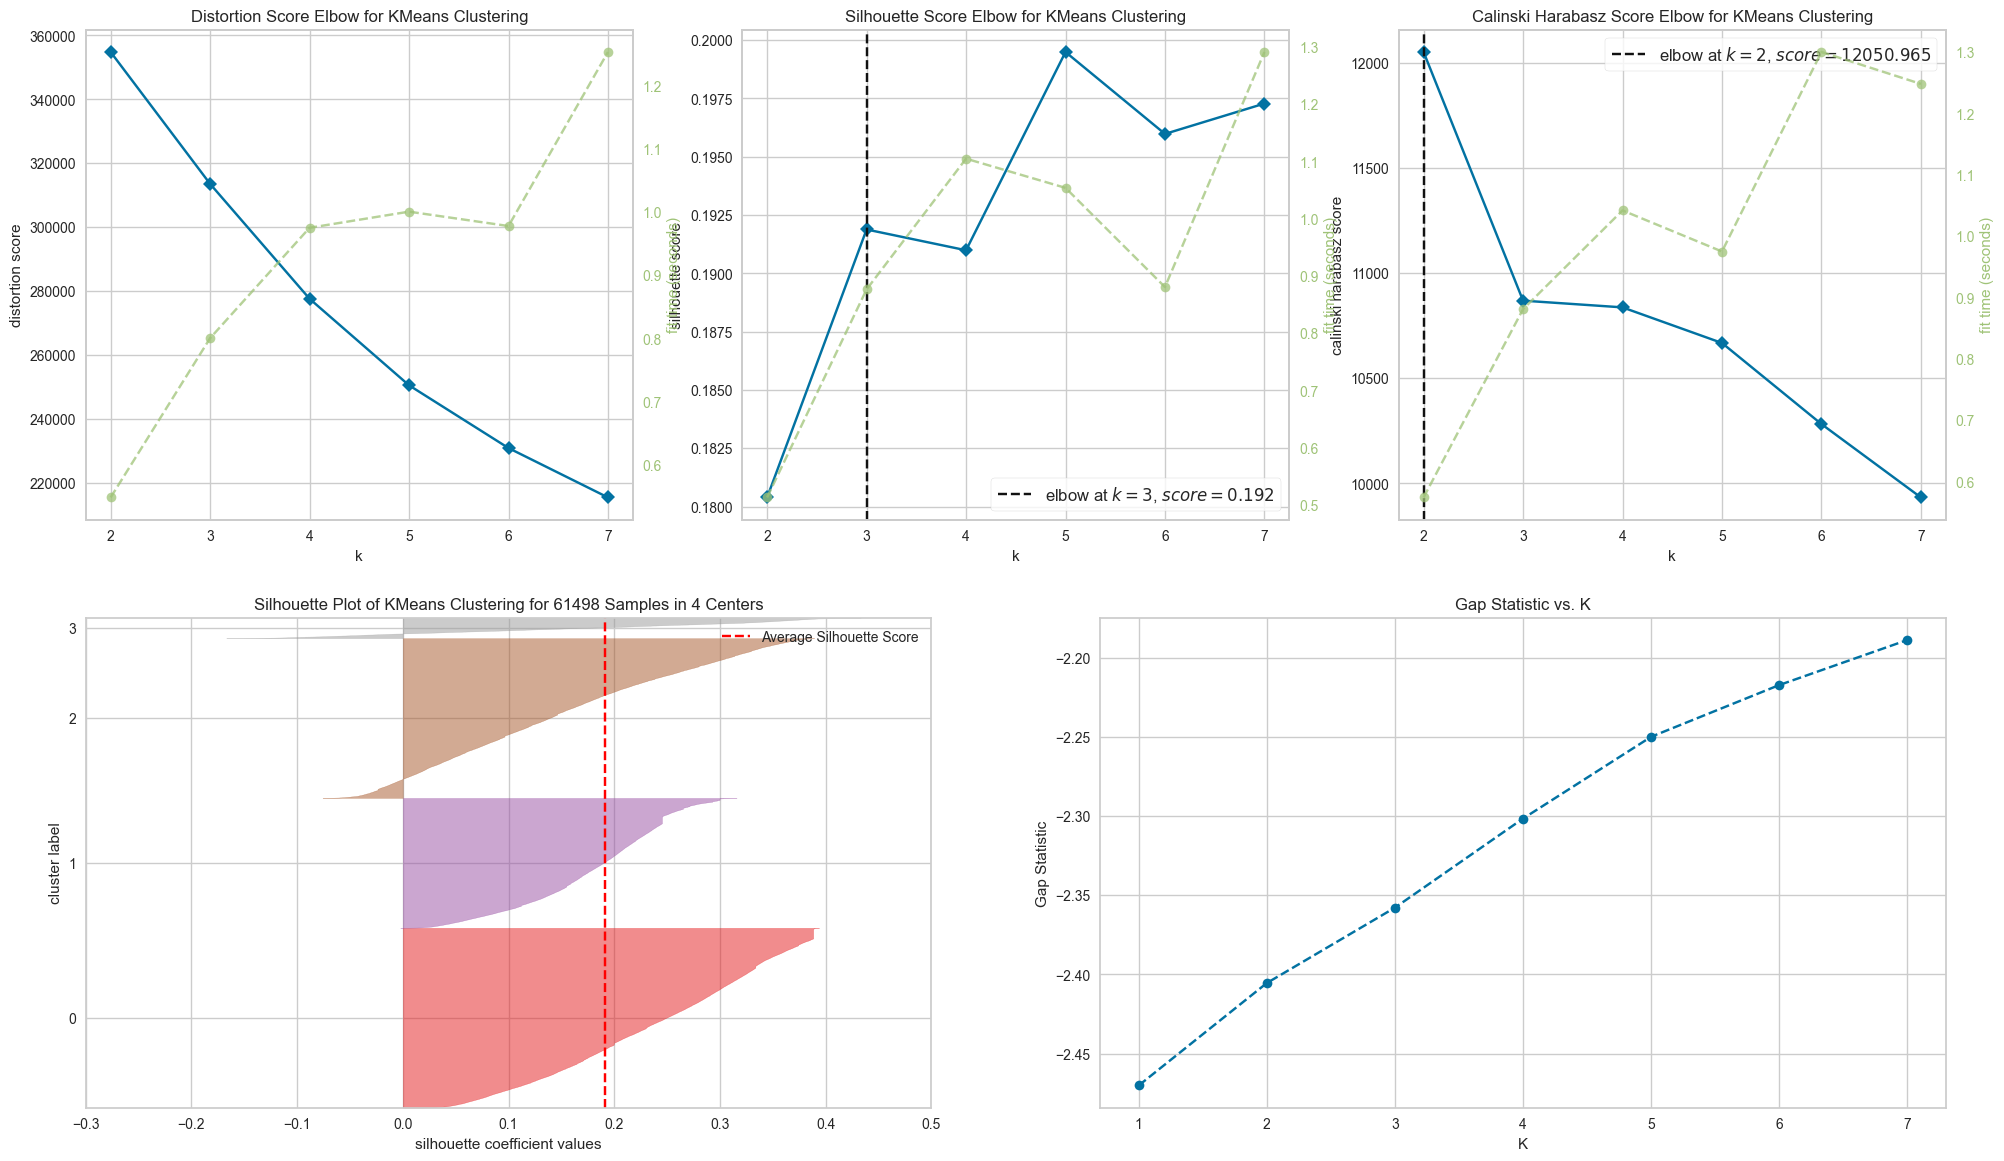

C:\Users\julie\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Temps d'exécution avec k = 4 : 1.008s
Indice de Gini : 0.20855149760967837


In [106]:
smpl = train_df.sample(frac=0.20)
smpl.reset_index(inplace=True)
smpl.drop(['index'], axis=1, inplace=True)

cluster_feats = ['EXT_SOURCE_1', 'EXT_SOURCE_3', 
                 'CLOSED_DAYS_CREDIT_VAR', 
                 'ACTIVE_DAYS_CREDIT_VAR',
                 'PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN',
                 'PREV_NAME_CONTRACT_STATUS_Approved_MEAN',
                 'CODE_GENDER']
X_kmeans = smpl[cluster_feats]

X_kmeans = preprocessor.fit_transform(X_kmeans)
names = preprocessor.get_feature_names_out()
feature_names = []
for name in names:
    name1 = name.replace('pipeline-1__', '')
    name2 = name1.replace('pipeline-2__', '')
    feature_names.append(name2)

X_kmeans = pd.DataFrame(X_kmeans, columns=feature_names)
#X_kmeans.drop(['REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT_W_CITY', 'CNT_CHILDREN', 'HOUR_APPR_PROCESS_START'], axis=1, inplace=True)

train_df_kmeans, kmeans_centers = utils.kmeans_function(X_kmeans, K=4)

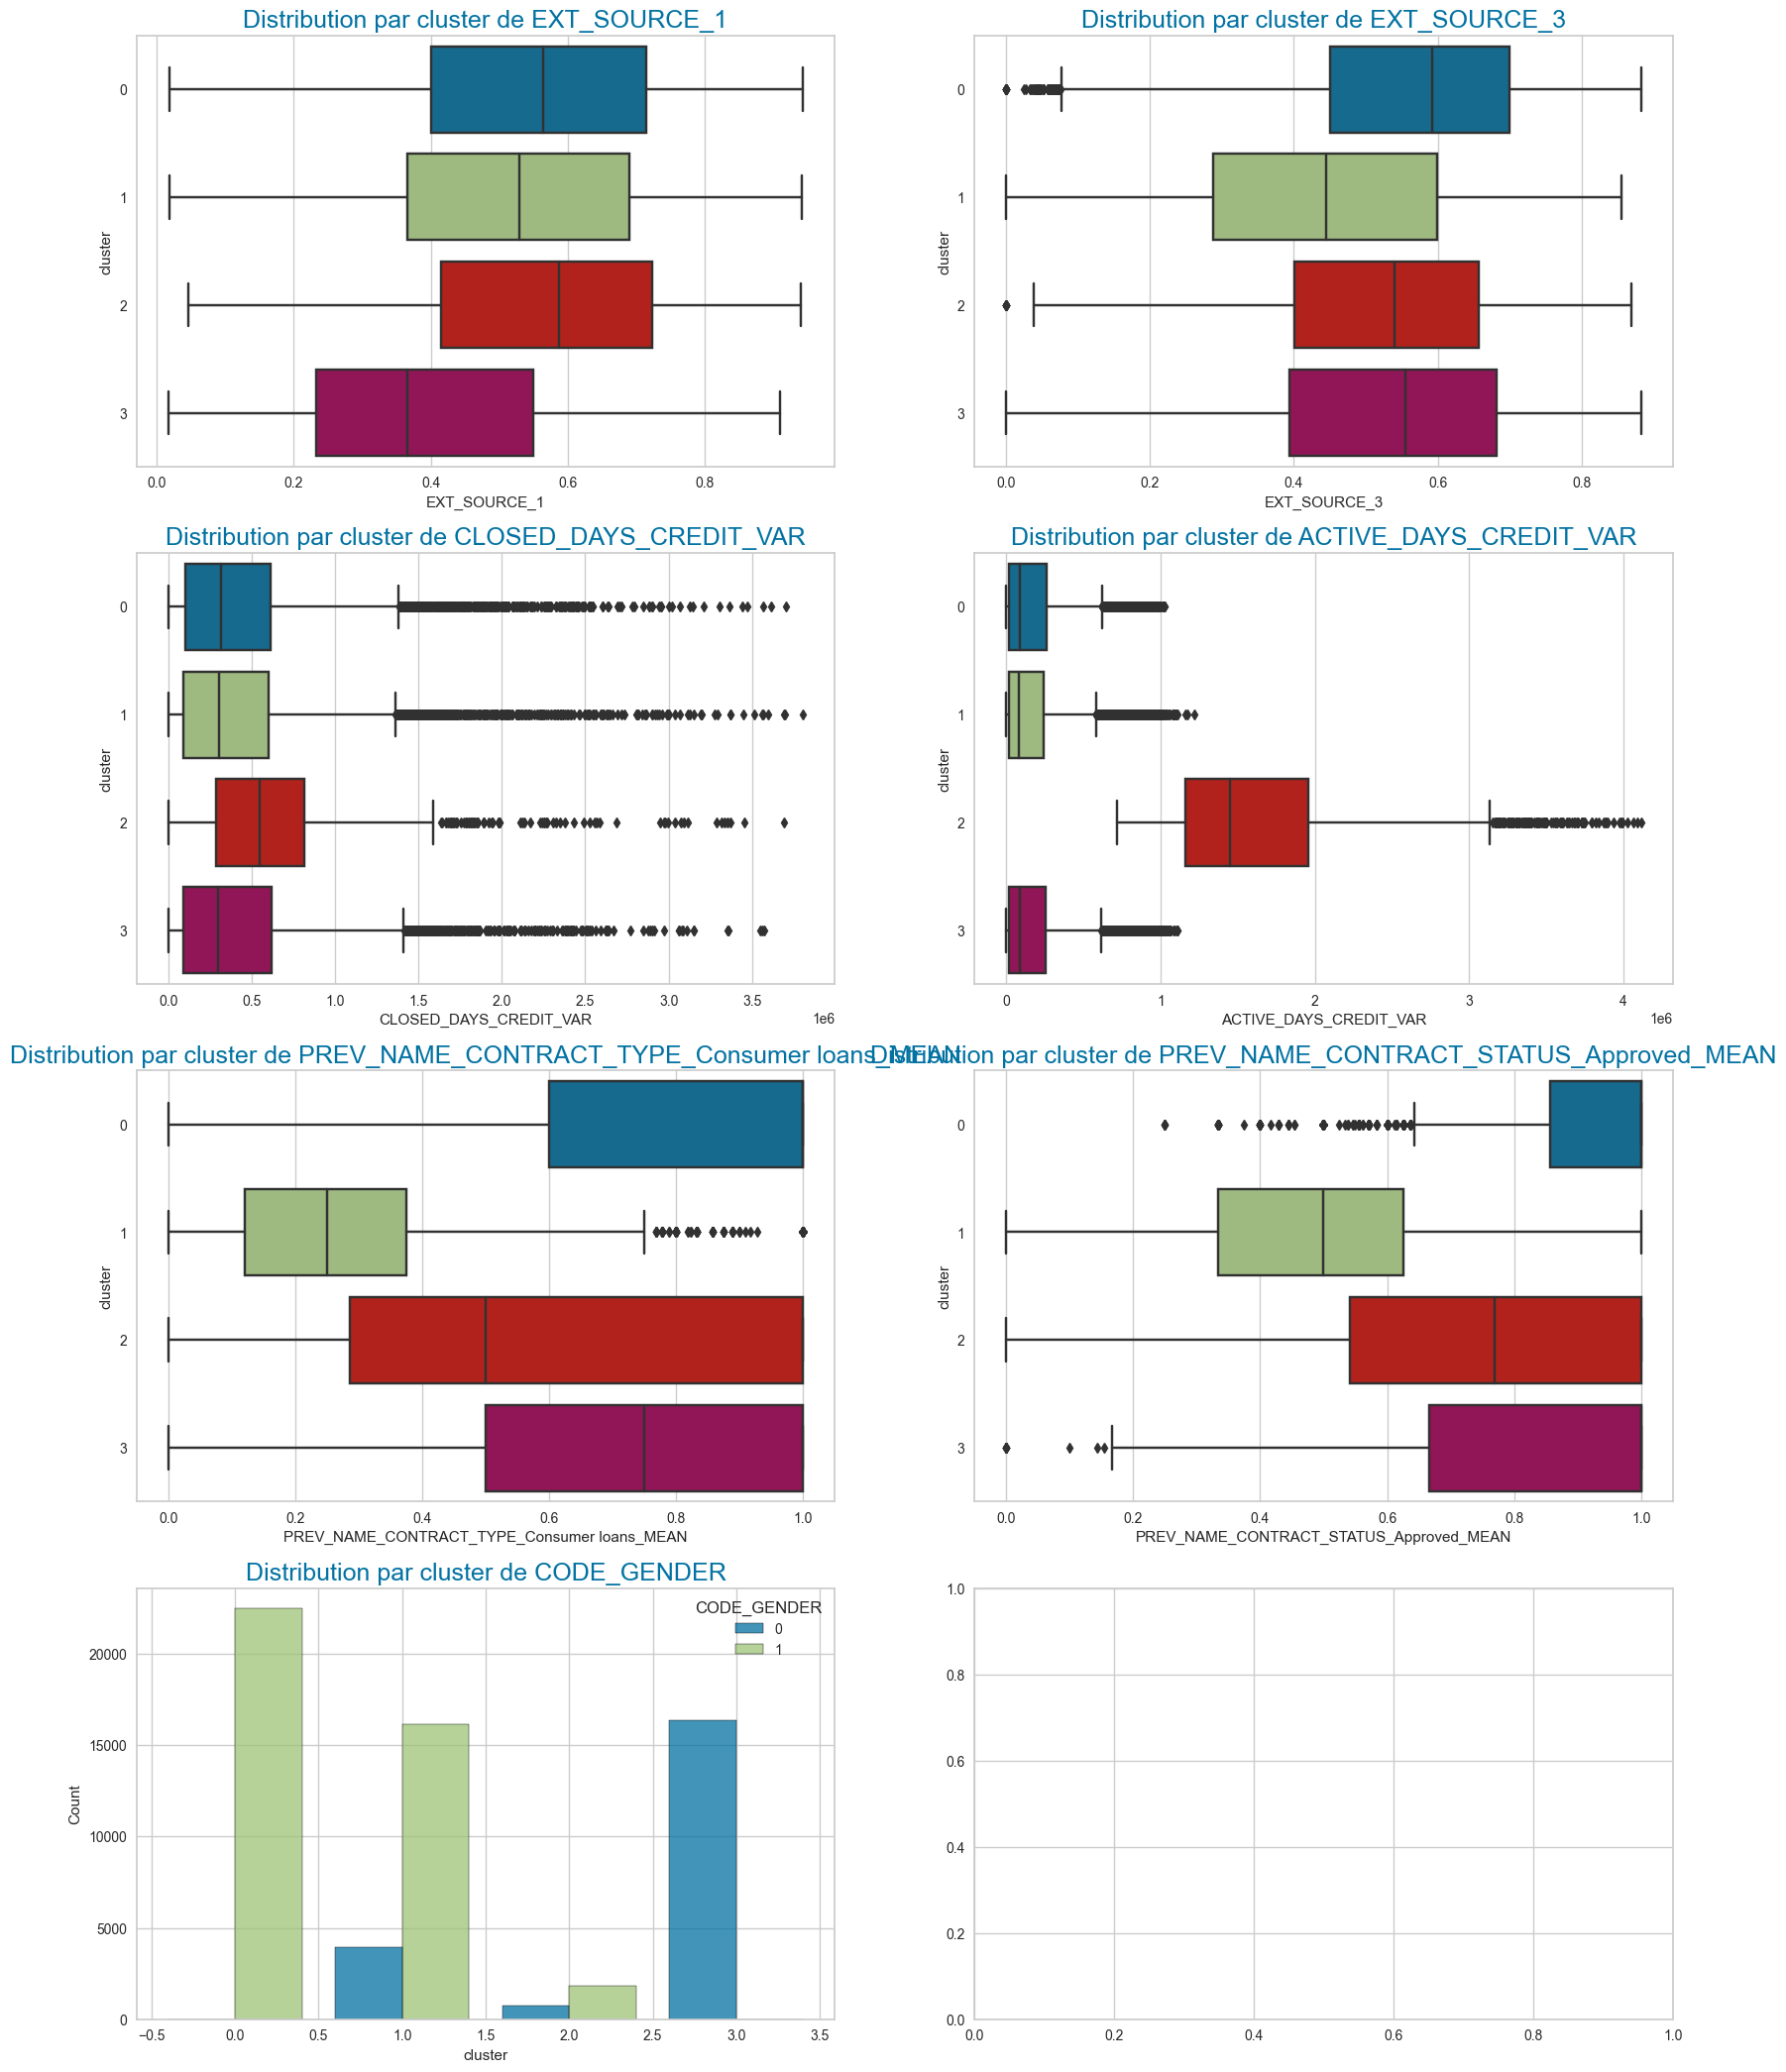

In [110]:
smpl['cluster'] = train_df_kmeans['cluster']

fig, axes = plt.subplots(4,2,figsize=(20,26))

data = smpl.copy()
feat_types = ['float64', 'float64', 'float64',
              'float64', 'float64', 'float64',
              'int64']

for axe, cat, dtype in zip(axes.flatten(), cluster_feats, feat_types):

    if dtype == 'float64':
        sns.boxplot(ax=axe, data=data, x=cat, y='cluster', orient='h')
        axe.set_title('Distribution par cluster de {}'.format(cat), color='b', fontsize=18)
    else :
        #data[cat] = data[cat].astype('int')
        sns.histplot(data=data, ax=axe, hue=cat, x='cluster', discrete=True, multiple='dodge', shrink=0.8)
        axe.set_title('Distribution par cluster de {}'.format(cat), color='b', fontsize=18)

In [111]:
smpl.to_csv('streamlit_dashboard/data_streamlit.csv', index=False)